In [15]:
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from time import time

# Preprocessing

In [16]:
file_path = './caltech101_silhouettes_28.mat'
data = loadmat(file_path)

In [17]:
images = np.array([data["X"][index].reshape((1, 28, 28)).T for index in range(len(data["X"]))])
labels = np.array(data["Y"][0])

# Plot an example

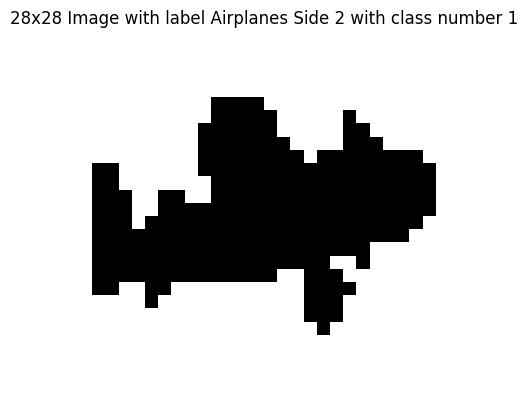

In [18]:
index = 10
image = data["X"][index].reshape((28, 28)).T
label = data["Y"][0][index]
plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale
plt.title(f"28x28 Image with label {data["classnames"][0][label-1][0]} with class number {label}")
plt.axis('off')
plt.show()

# Creating model

In [19]:
def create_cnn_model(nb_blocks, filters, activation_fn, input_shape, output_classes):
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))

    for i in range(nb_blocks):
        model.add(layers.Conv2D(filters[i], kernel_size=(3, 3), activation=activation_fn, padding="same"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(output_classes, activation='softmax'))

    return model

In [20]:
def evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, epochs, batch_size):
    model.compile(optimizer=optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    initial_time = time()
    history = model.fit(x_train, y_train, 
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    training_time = time() - initial_time
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    validation_time = time() - training_time - initial_time
    return training_time, validation_time, test_loss, test_accuracy

In [23]:
def run_experiments(data, labels, configs, epochs=20, batch_size=32):
    results = []

    for config in configs:
        nb_blocks = config['nb_blocks']
        filters = config['filters']
        activation_fn = config['activation_fn']
        data_split = config['data_split']

        # Data Splitting
        x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=(1-data_split[0]))
        val_split = data_split[1] / (data_split[1] + data_split[2])
        x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1-val_split))

        # Encode Labels
        y_train = tf.keras.utils.to_categorical(y_train)
        y_val = tf.keras.utils.to_categorical(y_val)
        y_test = tf.keras.utils.to_categorical(y_test)

        # Run Model 3 Times
        accuracies = []
        training_times = []
        validation_times = []
        for _ in range(3):
            model = create_cnn_model(nb_blocks, filters, activation_fn, data.shape[1:], labels.max() + 1)
            training_time, validation_time, loss, accuracy = evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, epochs, batch_size)
            print(f"Evaluated {nb_blocks}, {filters}, {activation_fn} with accuracy {accuracy}")
            accuracies.append(accuracy)
            training_times.append(training_time)
            validation_times.append(validation_time)
            
        mean_accuracy = np.mean(accuracies)
        mean_training_time = np.mean(training_times)
        mean_validation_time = np.mean(validation_times)
        results.append({
            'config': config,
            'mean_accuracy': mean_accuracy,
            'training_time': mean_training_time,
            'validation_time': mean_validation_time
        })

    return pd.DataFrame(results)

# Testing the different configs

In [24]:
nb_blocks_options = [1, 3]
filters_options = [
    [128],                    # with nb_blocks=1
    [32, 64, 128]             # with nb_blocks=3
]
activation_fn_options = ['sigmoid', 'relu']
data_split_options = [(0.8, 0.1, 0.1), (0.4, 0.2, 0.4), (0.1, 0.1, 0.8)]

In [25]:
configs = []
for nb_blocks, filters in zip(nb_blocks_options, filters_options):
    for activation_fn, data_split in itertools.product(activation_fn_options, data_split_options):
        configs.append({
            'nb_blocks': nb_blocks,
            'filters': filters,
            'activation_fn': activation_fn,
            'data_split': data_split
        })
configs

[{'nb_blocks': 1,
  'filters': [128],
  'activation_fn': 'sigmoid',
  'data_split': (0.8, 0.1, 0.1)},
 {'nb_blocks': 1,
  'filters': [128],
  'activation_fn': 'sigmoid',
  'data_split': (0.4, 0.2, 0.4)},
 {'nb_blocks': 1,
  'filters': [128],
  'activation_fn': 'sigmoid',
  'data_split': (0.1, 0.1, 0.8)},
 {'nb_blocks': 1,
  'filters': [128],
  'activation_fn': 'relu',
  'data_split': (0.8, 0.1, 0.1)},
 {'nb_blocks': 1,
  'filters': [128],
  'activation_fn': 'relu',
  'data_split': (0.4, 0.2, 0.4)},
 {'nb_blocks': 1,
  'filters': [128],
  'activation_fn': 'relu',
  'data_split': (0.1, 0.1, 0.8)},
 {'nb_blocks': 3,
  'filters': [32, 64, 128],
  'activation_fn': 'sigmoid',
  'data_split': (0.8, 0.1, 0.1)},
 {'nb_blocks': 3,
  'filters': [32, 64, 128],
  'activation_fn': 'sigmoid',
  'data_split': (0.4, 0.2, 0.4)},
 {'nb_blocks': 3,
  'filters': [32, 64, 128],
  'activation_fn': 'sigmoid',
  'data_split': (0.1, 0.1, 0.8)},
 {'nb_blocks': 3,
  'filters': [32, 64, 128],
  'activation_fn': 'r

In [12]:
results_df = run_experiments(images, labels, configs)
print(results_df)

2024-12-18 15:19:01.634203: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


KeyboardInterrupt: 